# PINNS on Vertex AI
Code accompanying the [article](https://medium.com/@gmarchetti/pinns-with-colab-enterprise-d5a1e16572a4)

## Install dependencies

In [19]:
%pip install -U tensorflow tensorflow_probability[tf]
%pip install deepxde
%pip install --upgrade google-cloud-aiplatform
%pip install --upgrade google-cloud-aiplatform[autologging]

## Set parameters

In [1]:
PROJECT_ID = "<your_project_id>"  # @param {type:"string"}
REGION = "us-central1"  # @param {type: "string"}
BUCKET_URI = "gs://<your_bucket>"  # @param {type:"string"}
EXPERIMENT_NAME = "experiments-pinns"  # @param {type:"string"}

In [2]:
! gcloud config set project {PROJECT_ID}

# Only if your bucket doesn't already exist: Uncomment the following code to create your Cloud Storage bucket.
! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

Updated property [core/project].


## Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math as m
import random
import datetime
import os
import sys
import argparse
import glob
from google.cloud import storage


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



In [4]:
#from tensorflow.python.ops.numpy_ops import np_config
#np_config.enable_numpy_behavior()
#os.environ['TF_USE_LEGACY_KERAS'] = '1'

## Tensorflow example
### Neural network

In [5]:
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])
NN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97 (776.00 B)

 Trainable params: 97 (776.00 B)

 Non-trainable params: 0 (0.00 B)

### Loss function

In [8]:
def L_w(t, nn):
    t = t.reshape(-1,1)
    t = tf.constant(t, dtype = tf.float32)
    t_0 = tf.zeros((1,1), dtype = tf.float32)
    one = tf.ones((1,1), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(t)

        u = nn(t) # compute neural network output
        u_t = tape.gradient(u, t) # compute derivative

    loss = u_t - tf.math.cos(2*np.pi*t) # computation loss
    loss0 = nn(t_0)-one #initial condition loss

    loss2 = tf.square(loss) + tf.square(loss0) # sum of squares
    total_loss = tf.reduce_mean(loss2) # compute MSE

    return total_loss

### Train


In [9]:
opt=tf.keras.optimizers.Adam(learning_rate=1e-3)

In [10]:
train_t = (np.random.rand(30)*2.0).reshape(-1, 1) # generate some training samples
train_loss_record = [] # to keep history of loss values
tf.config.run_functions_eagerly(True) # eager execution to view intermediate outputs

for i in range(6000):
    with tf.GradientTape() as tape:
        train_loss = L_w(train_t, NN) # compute loss
        train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables) # compute gradients
        opt.apply_gradients(zip(grad_w, NN.trainable_variables)) # back propagation

    if i % 100 == 0:
        print(train_loss.numpy())

1.542899216408188
0.512146982845762
0.4830975236690653
0.4797442938364006
0.47820970565342386
0.47520720982515996
0.4685163803214633
0.4543696896971981
0.4269248873477062
0.3840244638519907
0.3353131761305839
0.2933195159493709
0.26367993973422643
0.24582109956783532
0.23557480802531824
0.22862382378712637
0.2226909580272348
0.2171040198683329
0.211906187205017
0.2069934434519176
0.20197390945605792
0.19664376258154725
0.19085188601430372
0.18436034061823223
0.17710704189111362
0.16931337632686982
0.16155178259531475
0.15452356980305385
0.14854998600542152
0.1433739045784343
0.13834132187642748
0.13265110883214273
0.12541875691327065
0.11556348804618818
0.10192244529324072
0.08427126779973838
0.06482962058947751
0.047460944963220605
0.03444773792263523
0.025273320395419886
0.018786151874517223
0.01420099189149796
0.011019927706526746
0.008842607523977133
0.007343835135092517
0.0062935143199137145
0.005532986175063218
0.004955735384391439
0.004485859445655468
0.004079421583967269
0.0037

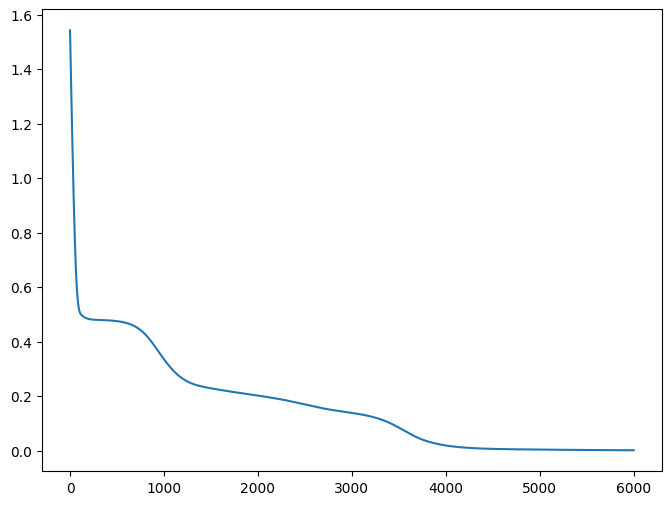

In [11]:
plt.figure(figsize = (8,6))
plt.plot(train_loss_record)
plt.show()

### Plot solution


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


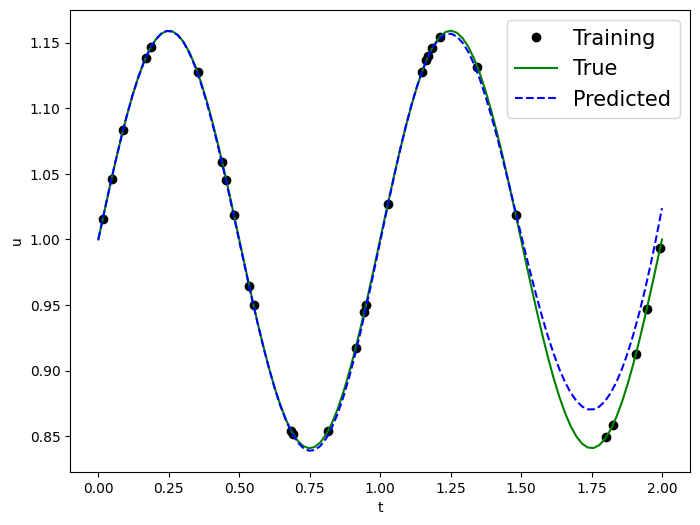

In [12]:
# generate some test points
test_t = np.linspace(0, 2, 100)

train_u = np.sin(2*np.pi*train_t)/(2*np.pi) + 1
true_u = np.sin(2*np.pi*test_t)/(2*np.pi) + 1
# compute approximation
pred_u = NN.predict(test_t).ravel()

plt.figure(figsize = (8,6))
plt.plot(train_t, train_u, 'ok', label = 'Training')
plt.plot(test_t, true_u, '-g',label = 'True')
plt.plot(test_t, pred_u, '--b', label = 'Predicted')
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 10)
plt.ylabel('u', fontsize = 10)
plt.show()

## Now with DeepXDE

### Define the loss
using the Jacobian (first derivative, multidimensional) operator




In [ ]:
import deepxde as dde

In [4]:
pi = tf.constant(m.pi)

def ode_system(t, u):
    du_t = dde.grad.jacobian(u, t)
    return du_t - tf.math.cos(2*pi*t)

### Define the initial condition

In [5]:
def boundary(t, on_initial):
  return on_initial and np.isclose(t[0],0)

### Define the geometry of the problem

In [6]:
# time domain between 0 and 2
geom = dde.geometry.TimeDomain(0, 2)

# initial condition u(boundary) = 1
ic = dde.IC(geom, lambda t: 1, boundary)

# Analytical solution to compute error
def true_solution(t):
    return np.sin(2*np.pi*t)/(2*np.pi) + 1


### Define the system

In [7]:
data = dde.data.PDE(geom, # geometry
                    ode_system, # loss
                    ic, # initial conditions
                    num_domain = 30, # training samples
                    num_boundary = 2, # boundary samples
                    solution = true_solution, # reference solution
                    num_test = 100 # test samples
                    )

### Neural network approximator


In [8]:
layer_size = [1] + [32] + [1]
activation = "tanh"
initializer = "Glorot uniform"

NN = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, NN)
model.compile("adam", lr = 0.001)

Compiling model...
'compile' took 0.009231 s



Training model...



Cause: could not parse the source code of <function <lambda> at 0x7b883912b9a0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7b883912b9a0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss              Test loss               Test metric
0         [4.06e+00, 1.00e+00]    [4.08e+00, 1.00e+00]    []  
1000      [5.00e-01, 3.93e-06]    [4.93e-01, 3.93e-06]    []  
2000      [4.97e-01, 9.06e-06]    [4.91e-01, 9.06e-06]    []  
3000      [4.90e-01, 1.37e-05]    [4.86e-01, 1.37e-05]    []  
4000      [4.87e-01, 6.56e-06]    [4.85e-01, 6.56e-06]    []  
5000      [6.42e-02, 5.36e-06]    [6.41e-02, 5.36e-06]    []  
6000      [1.46e-03, 2.06e-07]    [9.67e-04, 2.06e-07]    []  

Best

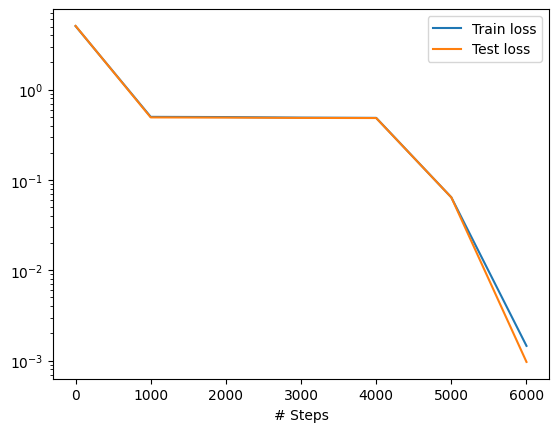

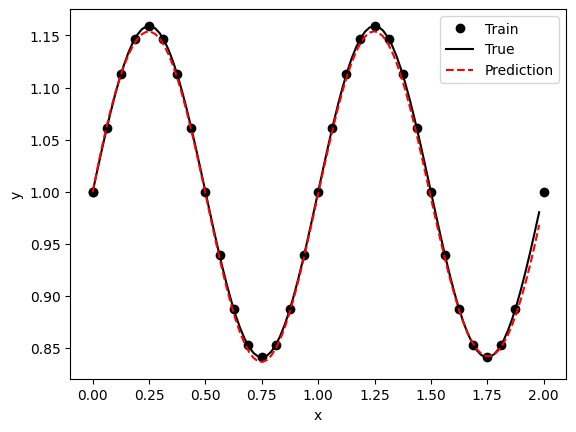

In [9]:
## Train
losshistory, train_state = model.train(epochs = 6000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

## Equations of Navier-Stokes

## Start experiment

In [ ]:
from google.cloud import aiplatform
aiplatform.init(
    project=PROJECT_ID,
    staging_bucket=BUCKET_URI,
    location=REGION,
    experiment=EXPERIMENT_NAME)

#aiplatform.autolog()

In [ ]:
# Properties
rho = 1
mu = 1
u_in = 1
D = 1
L = 2

In [ ]:
def boundary_wall(X, on_boundary):
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2)), on_boundary)
    return on_wall

def boundary_inlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], -L/2)

def boundary_outlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], L/2)

In [ ]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i = 0, j = 0)
    du_y = dde.grad.jacobian(Y, X, i = 0, j = 1)
    dv_x = dde.grad.jacobian(Y, X, i = 1, j = 0)
    dv_y = dde.grad.jacobian(Y, X, i = 1, j = 1)
    dp_x = dde.grad.jacobian(Y, X, i = 2, j = 0)
    dp_y = dde.grad.jacobian(Y, X, i = 2, j = 1)
    du_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 0)
    du_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 0)
    dv_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 1)
    dv_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 1)

    pde_u = Y[:,0:1]*du_x + Y[:,1:2]*du_y + 1/rho * dp_x - (mu/rho)*(du_xx + du_yy)
    pde_v = Y[:,0:1]*dv_x + Y[:,1:2]*dv_y + 1/rho * dp_y - (mu/rho)*(dv_xx + dv_yy)
    pde_cont = du_x + dv_y

    return [pde_u, pde_v, pde_cont]

In [ ]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

bc_wall_u = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 1)

bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component = 0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_inlet, component = 1)

bc_outlet_p = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 1)

In [ ]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u, bc_wall_v, bc_inlet_u, bc_inlet_v, bc_outlet_p, bc_outlet_v],
                    num_domain = 2000,
                    num_boundary = 200,
                    num_test = 100,
                   )

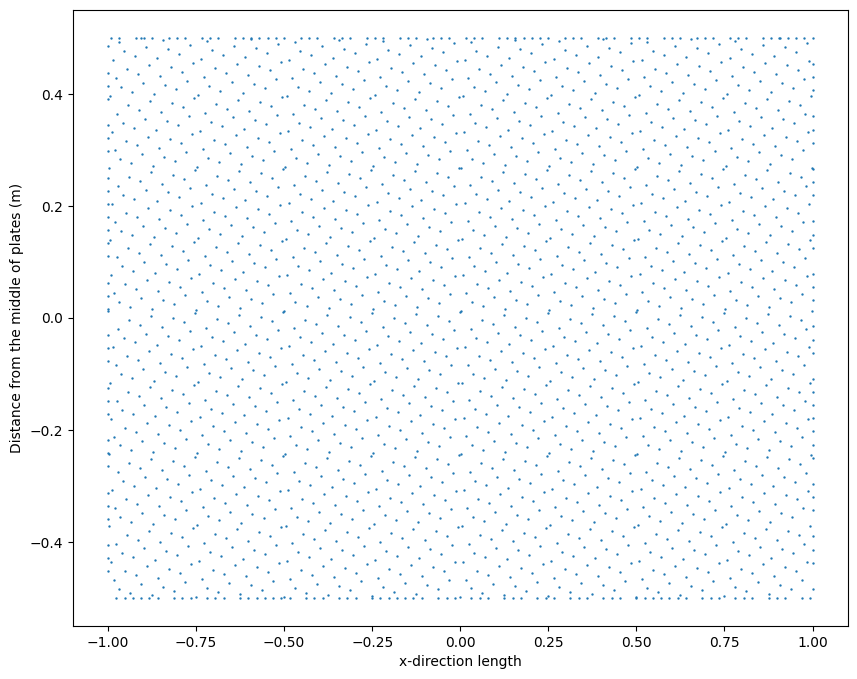

In [ ]:
plt.figure(figsize = (10,8))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.5)
plt.xlabel('x-direction length')
plt.ylabel('Distance from the middle of plates (m)')
plt.show()

In [ ]:
layer_size = [2] + [32] * 5 + [3]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile("adam", lr = 1e-3,  )

Compiling model...
'compile' took 0.002508 s



In [ ]:
checker = dde.callbacks.ModelCheckpoint(
    "model/model.ckpt", save_better_only=True, period=1000
)

In [ ]:
# you really want 10000, but it will take a long time on cpu. reduced to 
ITERATIONS1=1000  #@param {type: "integer"}
OUTPUT_BLOB="gs://<your output location/>" #@param {type: "string"}
OUTPUT_FILE="pinns-adam"

In [ ]:
run=aiplatform.start_run(run="pinns-adam"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")) # Optional - name and start experiment run
losshistory, train_state = model.train(iterations = ITERATIONS1, callbacks=[checker], display_every=1000)

INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/222360216126/locations/us-central1/metadataStores/default/contexts/experiments-pinns-pinns-adam2024-04-14-21-16-40 to Experiment: experiments-pinns
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Training model...



Cause: could not parse the source code of <function <lambda> at 0x7eed143cb400>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7eed143cb400>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7eed143cbd00>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7eed143cbd00>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7eed1416c0d0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7eed1416c0d0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7eed1416c430>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7eed1416c430>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7eed1416c790>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7eed1416c790>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7eed1416caf0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7eed1416caf0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [2.02e-01, 1.15e-01, 1.56e-01, 1.10e-01, 3.14e-03, 2.62e-01, 1.65e-03, 1.42e-01, 1.65e-03]    [2.09e-01, 1.20e-01, 1.67e-01, 1.10e-01, 3.14e-03, 2.62e-01, 1.65e-03, 1.42e-01, 1.65e-03]    []  
1000      [3.19e-03, 1.12e-03, 1.53e-02, 4.20e-02, 1.85e-02, 3.80e-02, 1.04e-02, 3.71e-04, 6.17e-05]    [2.05e-03, 5.28e-04, 9.91e-03, 4.20e-02, 1.85e-02, 3.80e-02, 1.04e-02, 3.71e-04, 6.17e-05]    []  
2000      [8.80e-04, 9.08e-04, 6.49e-03, 2.68e-02, 1.12e-02, 3.78e-02, 1.29e-03,

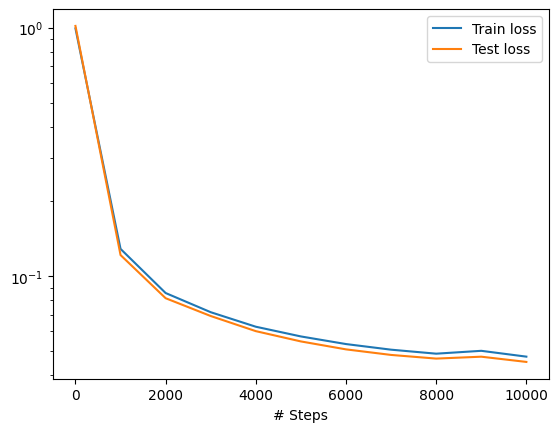

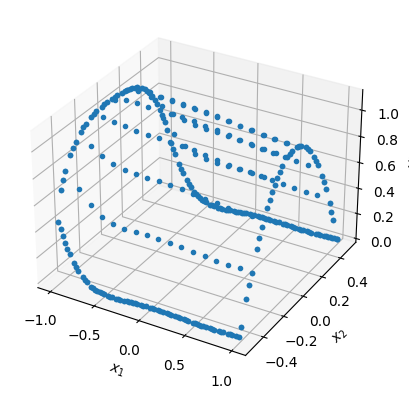

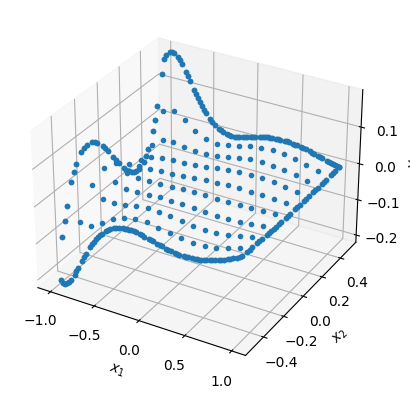

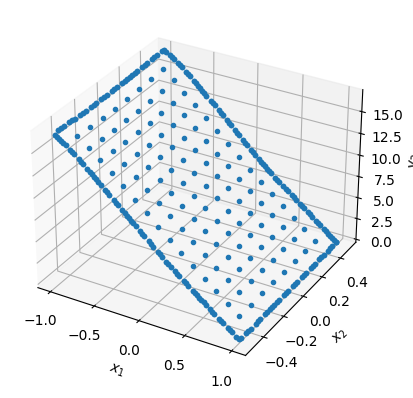

In [ ]:
#model.restore("model/model.ckpt-<iteration n.>", verbose=1) # if best model is not the last iteration
model.save(OUTPUT_FILE)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)
!gsutil cp $OUTPUT_FILE* $OUTPUT_BLOB

## Record progress
As deepxde does not implement metric logging, we have to record progress manually after training.

In [ ]:
for i in range(len(losshistory.steps)):
  print(np.sum(losshistory.loss_train[i]), np.sum(losshistory.loss_test[i]), losshistory.steps[i])
  aiplatform.log_time_series_metrics({"train_loss": np.sum(losshistory.loss_train[i]),
                                      "test_loss": np.sum(losshistory.loss_test[i])},
                                      step= losshistory.steps[i])

0.9937372986039279 1.0168338542617696 0
0.1288569743135484 0.1217197435206382 1000
0.08561296902208997 0.08159514345449298 2000
0.07167325166706483 0.06918893266789518 3000
0.06265315415850536 0.06013708568747652 4000
0.0572607456964847 0.05467350180411748 5000
0.05335625990221543 0.05079636722249828 6000
0.050650394017312285 0.04824506669021581 7000
0.04880785187704332 0.04663791473126627 8000
0.050118938916245526 0.04746373224903639 9000
0.04748643337235172 0.04521964051051191 10000


In [ ]:
aiplatform.log_metrics({"best_loss_train": model.train_state.best_loss_train.astype(float),
                        "best_loss_test": model.train_state.best_loss_test.astype(float),
                        "best_step": int(model.train_state.best_step),
                        "optimizer": "adam",
                        "iterations": ITERATIONS1
                        })

Alas deepxde models cannot be recorded as vertex ai platform models, so we'll record them as generic artifacts.

In [ ]:
artifact = aiplatform.Artifact.create(
        schema_title="system.Artifact",
        uri=OUTPUT_BLOB,
        #resource_id=resource_id,
        display_name="pinns-adam"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"),
        #schema_version=schema_version,
        description="Pinns model with adam optimizer",
        #metadata=metadata,
        #project=project,
        #location=location,
    )

In [ ]:
aiplatform.end_run() # End experiment run if manually started above


### Plot results

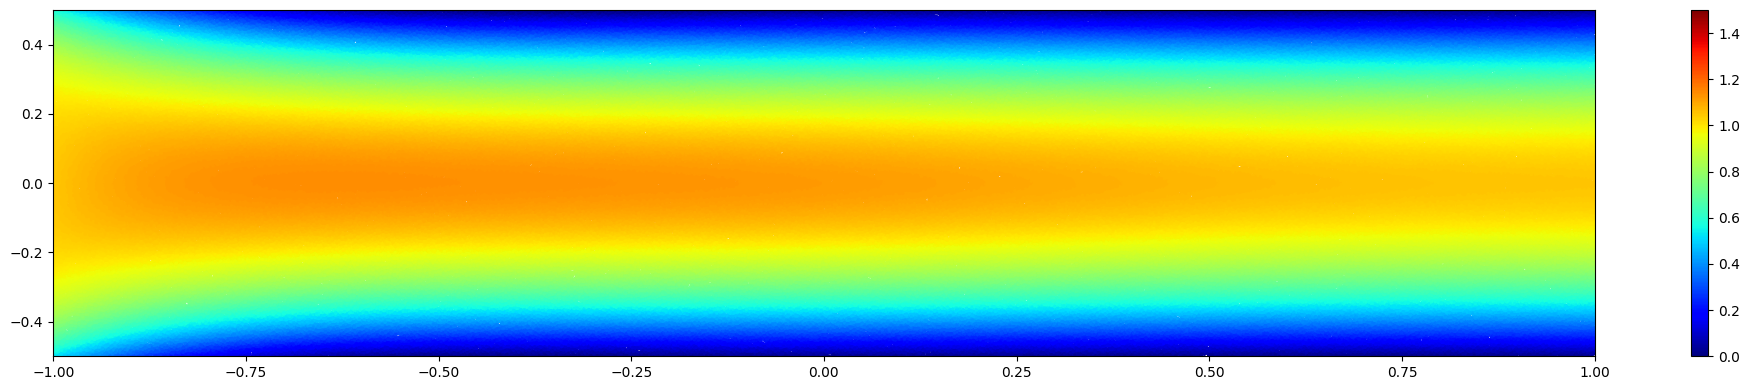

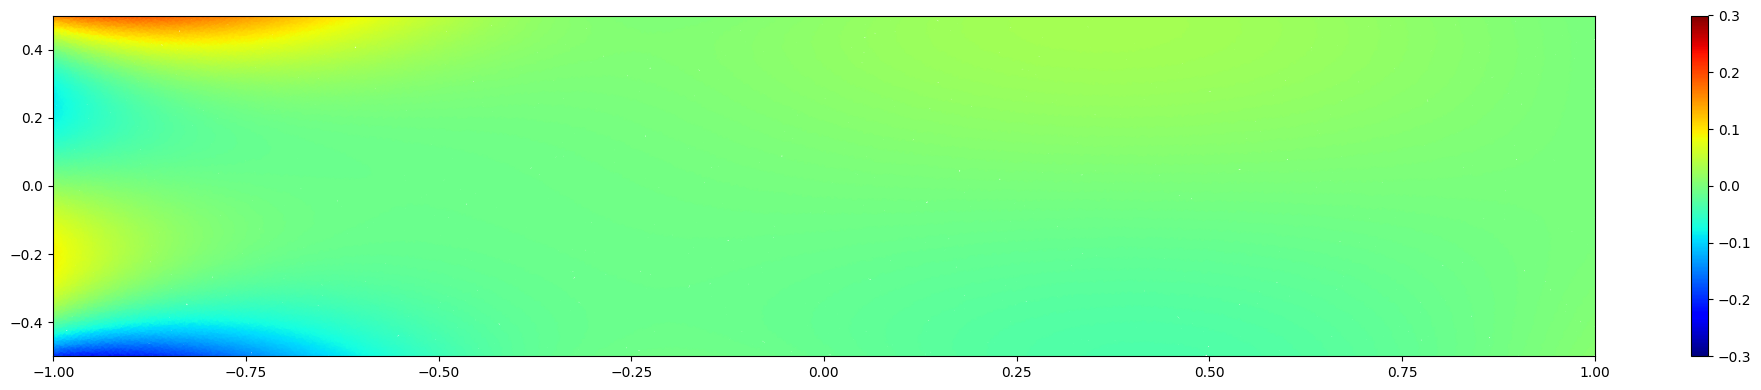

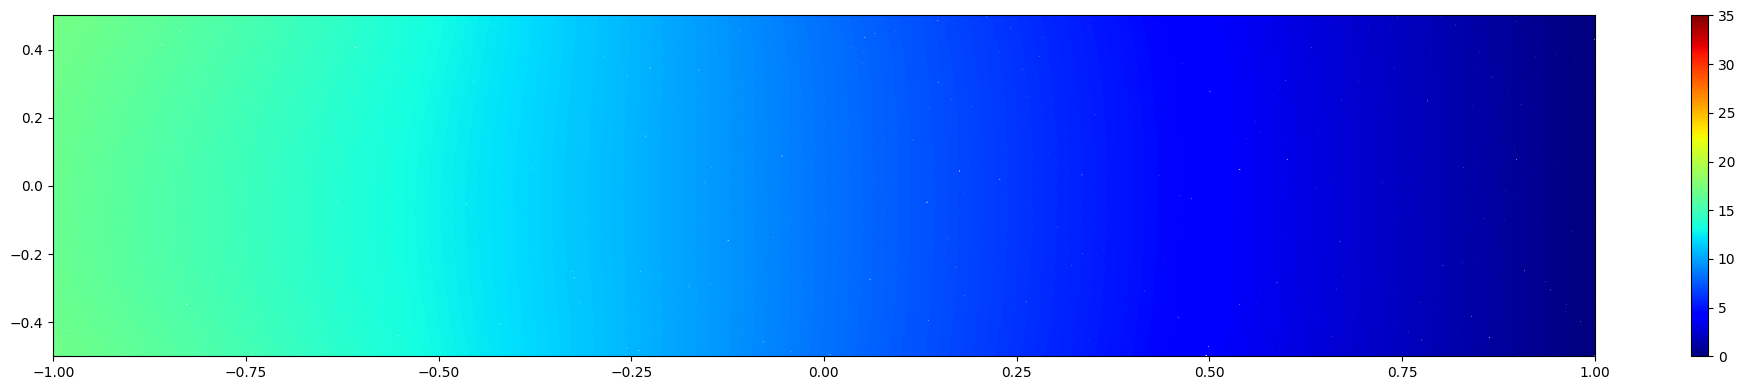

In [ ]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize = (20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                cmap = 'jet',
                s = 2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.savefig("pinns-adam-plot"+str(idx)+".png")
    plt.show()

## Change optimizer

In [ ]:
# you want 3000, but it will take forever on cpu, so reduced to:
ITERATIONS2=300 #@param {type: "integer"}
OUTPUT_BLOB="gs://<another output location>/" #@param {type: "string"}
OUTPUT_FILE="pinns-lbgfs.h5"

Compiling model...
'compile' took 0.009520 s



INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/222360216126/locations/us-central1/metadataStores/default/contexts/experiments-pinns-pinns-lbgfs2024-04-14-22-53-19 to Experiment: experiments-pinns


Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [1.01e-03, 5.69e-04, 2.30e-03, 1.51e-02, 5.96e-03, 1.80e-02, 4.47e-03, 8.72e-05, 8.85e-06]    [7.19e-04, 3.43e-04, 5.50e-04, 1.51e-02, 5.96e-03, 1.80e-02, 4.47e-03, 8.72e-05, 8.85e-06]    []  
13000     [4.09e-04, 3.85e-04, 6.92e-04, 5.28e-03, 8.72e-04, 5.41e-03, 1.76e-03, 2.39e-05, 1.76e-05]    [1.79e-04, 2.21e-04, 3.80e-04, 5.28e-03, 8.72e-04, 5.41e-03, 1.76e-03, 2.39e-05, 1.76e-05]    []  

Best model at step 13000:
  train loss: 1.49e-02
  test loss: 1.41e-02
  test metric: []

'train' took 943.868374 s



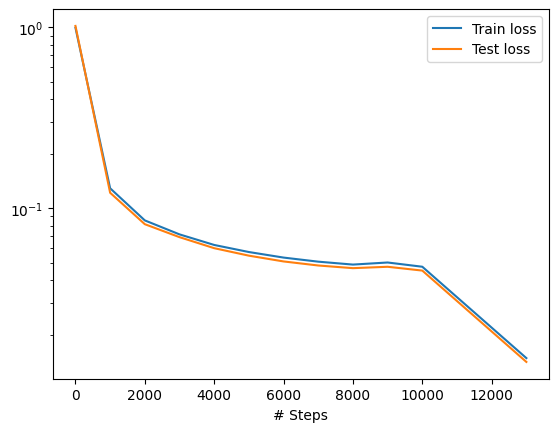

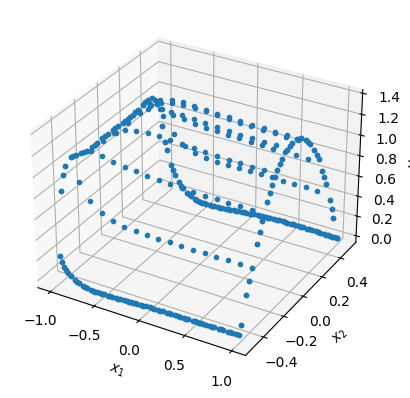

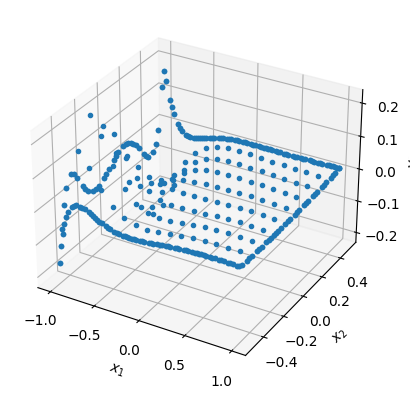

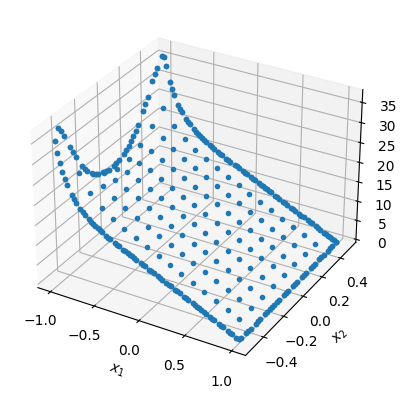

In [ ]:
dde.optimizers.config.set_LBFGS_options(maxiter = ITERATIONS2)

model.compile("L-BFGS")
aiplatform.start_run(run="pinns-lbgfs"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")) # Optional - name and start experiment run

losshistory, train_state = model.train()
model.save(OUTPUT_FILE)
#model.save(OUTPUT_BLOB)

dde.saveplot(losshistory, train_state, issave = False, isplot = True)
!gsutil cp $OUTPUT_FILE* $OUTPUT_BLOB

### Store metrics

In [ ]:
for i in range(len(losshistory.steps)):
  print(np.sum(losshistory.loss_train[i]), np.sum(losshistory.loss_test[i]), losshistory.steps[i])
  aiplatform.log_time_series_metrics({"train_loss": np.sum(losshistory.loss_train[i]),
                                      "test_loss": np.sum(losshistory.loss_test[i])},
                                      step= losshistory.steps[i])

0.9937372986039279 1.0168338542617696 0
0.1288569743135484 0.1217197435206382 1000
0.08561296902208997 0.08159514345449298 2000
0.07167325166706483 0.06918893266789518 3000
0.06265315415850536 0.06013708568747652 4000
0.0572607456964847 0.05467350180411748 5000
0.05335625990221543 0.05079636722249828 6000
0.050650394017312285 0.04824506669021581 7000
0.04880785187704332 0.04663791473126627 8000
0.050118938916245526 0.04746373224903639 9000
0.04748643337235172 0.04521964051051191 10000
0.04748643337235172 0.04521964051051191 10000
0.014850177144518554 0.014145322029515904 13000


In [ ]:
aiplatform.log_metrics({"best_loss_train": model.train_state.best_loss_train.astype(float),
                        "best_loss_test": model.train_state.best_loss_test.astype(float),
                        "best_step": int(model.train_state.best_step),
                        "optimizer": "lbgfs",
                        "iterations": ITERATIONS1+ITERATIONS2
                        })

In [ ]:
artifact = aiplatform.Artifact.create(
        schema_title="system.Artifact",
        uri=OUTPUT_BLOB,
        #resource_id=resource_id,
        display_name="pinns-lbgfs"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"),
        #schema_version=schema_version,
        description="Pinns model with lbgfs optimizer",
        #metadata=metadata,
        #project=project,
        #location=location,
    )

In [ ]:
aiplatform.end_run() # End experiment run if manually started above

### Plot results

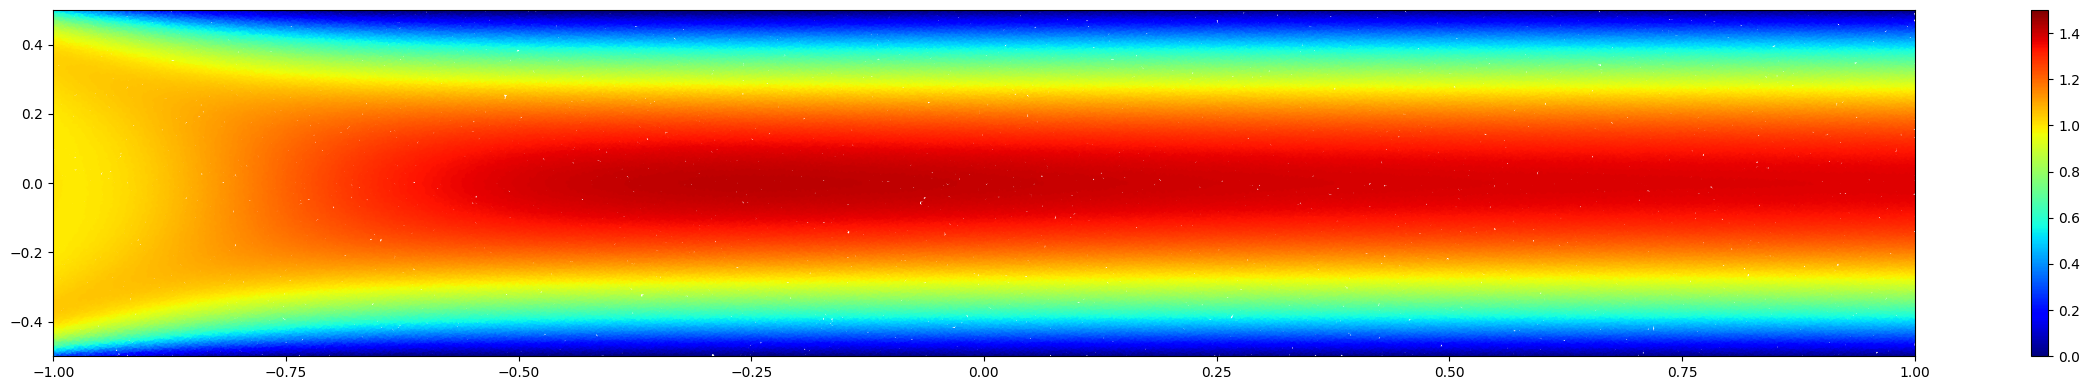

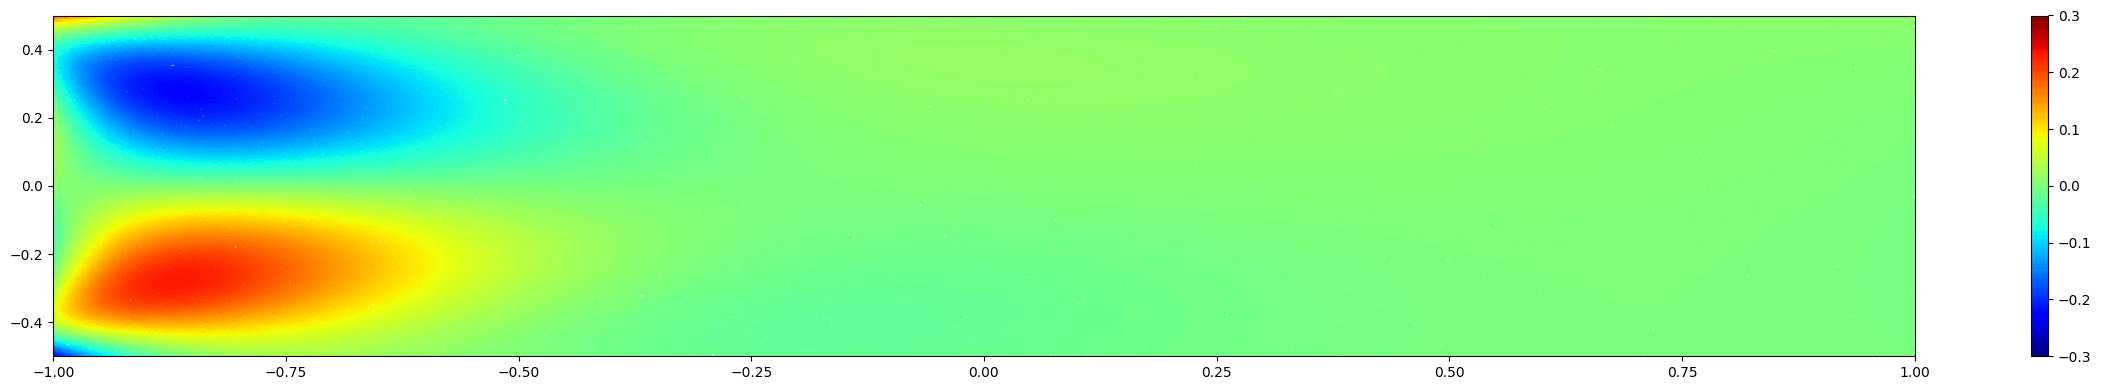

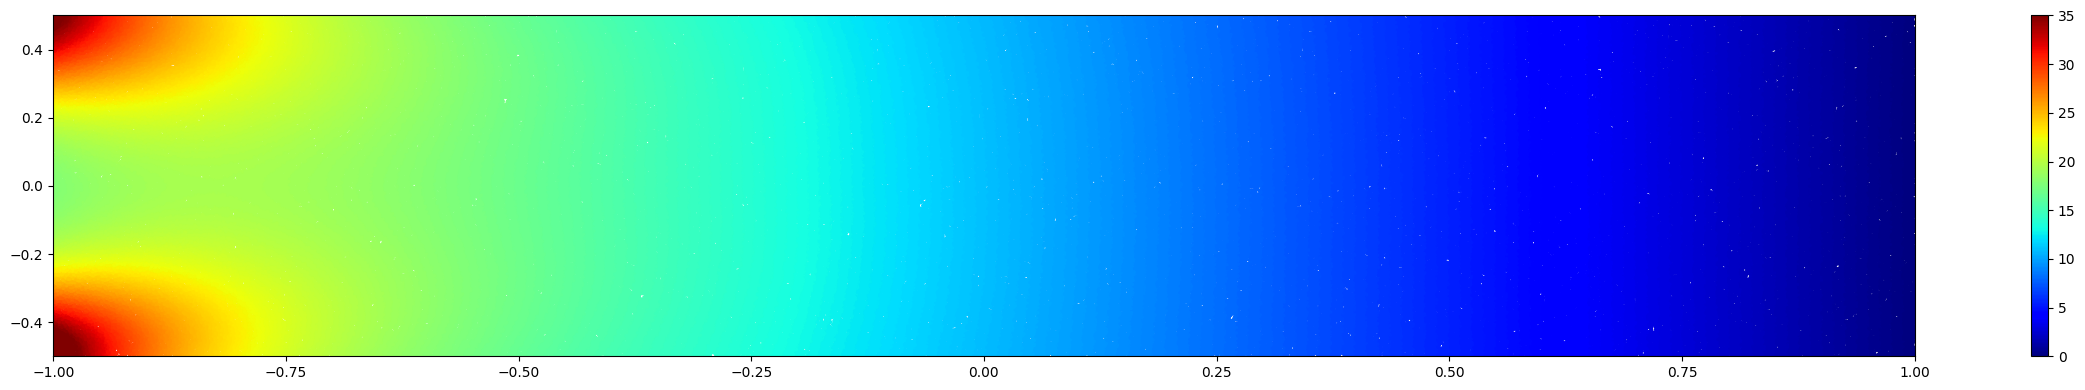

In [ ]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize = (24, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                cmap = 'jet',
                s = 2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.savefig("pinns-lbgfs-plot"+str(idx)+".png")
    plt.show()

In [ ]:
# Set the name of the bucket where you want to upload the files.
bucket_name = "<upload location>"

# Create a list of the files you want to upload.
files = glob.glob("*.png")

# Create a storage client.
client = storage.Client()

# Get the bucket.
bucket = client.bucket(bucket_name)

# Upload each file to the bucket.
for file in files:
    blob = bucket.blob(file)
    blob.upload_from_filename(file)

# Print a message to let the user know that the files have been uploaded.
print("The files have been uploaded to the bucket.")

The files have been uploaded to the bucket.


## Plot velocity profile

In [ ]:
# Analytic solution
x = np.ones([1000,1])
y = np.linspace(-0.5, 0.5, 1000).reshape(1000,1)
outlet = np.hstack([x, y])

analytic_solution = u_in * 1.5 * (1 - ((y)/(D/2))**2)

PINN_solution = model.predict(outlet)

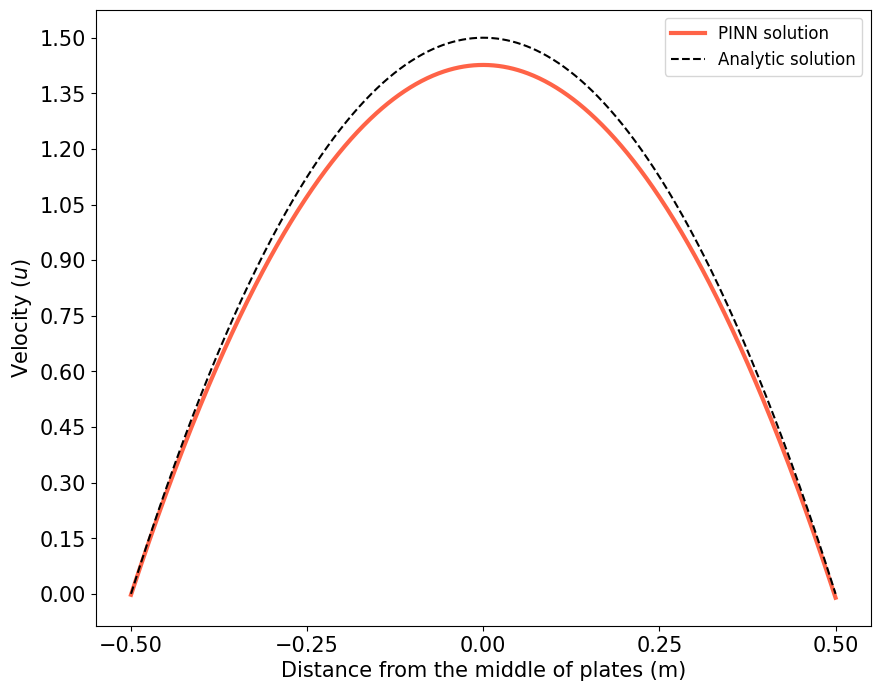

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(y, PINN_solution[:, 0], c = 'tomato', linewidth = 3, label = 'PINN solution')
plt.plot(y, analytic_solution, c = 'k', linestyle = '--', label = 'Analytic solution')
plt.xticks(np.linspace(-0.5, 0.5, 5), fontsize = 15)
plt.yticks(np.linspace(0, 1.5, 11), fontsize = 15)
plt.legend(fontsize = 12)
plt.xlabel('Distance from the middle of plates (m)', fontsize = 15)
plt.ylabel('Velocity ($u$)', fontsize = 15)
plt.show()

## Build Vertex AI Job
with final version of code to generate model

In [ ]:
%%writefile navier-stokes.py

PROJECT_ID = "your_project_id"
REGION = "us-central1"
BUCKET_URI = "gs://<staging bucket>"
EXPERIMENT_NAME = "experiments-pinns"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import deepxde as dde
import os
import glob
from google.cloud import storage
import argparse
import os

parser = argparse.ArgumentParser()
parser.add_argument('--rho', dest='rho',
                    default=1.0, type=float,
                    help='Density in Kg/m3')
parser.add_argument('--mu', dest='mu',
                    default=1.0, type=float,
                    help='Dynamic viscosity')
parser.add_argument('--u_in', dest='u_in',
                    default=1.0, type=float,
                    help='Initial velocity along x in m/s')
parser.add_argument('--D', dest='D', type=float, default=1.0,
                    help='Distance between plates in m')
parser.add_argument('--L', dest='L', type=float, default=2.0,
                    help='Length of plates in m')

parser.add_argument('--ITERATIONS1', dest='ITERATIONS1', type=int, default=10000,
                    help='Iterations w. Adam optimizer')

parser.add_argument('--ITERATIONS2', dest='ITERATIONS2', type=int, default=3000,
                    help='Iterations w. L-BGFS optimizer')

parser.add_argument('--BUCKET', dest='BUCKET', type=str,
                    help='Target GS bucket')

args = parser.parse_args()

dde.config.set_default_float("float64")
from deepxde.backend.set_default_backend import set_default_backend
set_default_backend("tensorflow")

# Properties
rho = args.rho
mu = args.mu
u_in = args.u_in
D = args.D
L = args.L

def boundary_wall(X, on_boundary):
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2)), on_boundary)
    return on_wall

def boundary_inlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], -L/2)

def boundary_outlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], L/2)

def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i = 0, j = 0)
    du_y = dde.grad.jacobian(Y, X, i = 0, j = 1)
    dv_x = dde.grad.jacobian(Y, X, i = 1, j = 0)
    dv_y = dde.grad.jacobian(Y, X, i = 1, j = 1)
    dp_x = dde.grad.jacobian(Y, X, i = 2, j = 0)
    dp_y = dde.grad.jacobian(Y, X, i = 2, j = 1)
    du_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 0)
    du_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 0)
    dv_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 1)
    dv_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 1)

    pde_u = Y[:,0:1]*du_x + Y[:,1:2]*du_y + 1/rho * dp_x - (mu/rho)*(du_xx + du_yy)
    pde_v = Y[:,0:1]*dv_x + Y[:,1:2]*dv_y + 1/rho * dp_y - (mu/rho)*(dv_xx + dv_yy)
    pde_cont = du_x + dv_y

    return [pde_u, pde_v, pde_cont]

geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

bc_wall_u = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 1)

bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component = 0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_inlet, component = 1)

bc_outlet_p = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 1)

data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u, bc_wall_v, bc_inlet_u, bc_inlet_v, bc_outlet_p, bc_outlet_v],
                    num_domain = 2000,
                    num_boundary = 200,
                    num_test = 100,
                   )

layer_size = [2] + [64] * 5 + [3]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile("adam", lr = 1e-3, loss="MSE", )

import datetime

ITERATIONS1=args.ITERATIONS1

#OUTPUT_BLOB="gs://gm-pinns/adam/pinns-adam"
MODEL_DIR = os.getenv("AIP_MODEL_DIR")

losshistory, train_state = model.train(iterations = ITERATIONS1)
#model.save("pinns-adam")
#model.save(OUTPUT_BLOB)
dde.saveplot(losshistory, train_state, issave = True, isplot = False)


ITERATIONS2=args.ITERATIONS2
#OUTPUT_BLOB="gs://gm-pinns/lbgfs/pinns-lbgfs"

dde.optimizers.config.set_LBFGS_options(maxiter = ITERATIONS2)

model.compile("L-BFGS")

losshistory, train_state = model.train()
#model.save("pinns-lbgfs.h5")
#model.save(OUTPUT_BLOB)
model.save(MODEL_DIR)

dde.saveplot(losshistory, train_state, issave = True, isplot = False)


samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize = (20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                cmap = 'jet',
                s = 2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.savefig("pinns-lbgfs-plot"+str(idx)+".png")


# Set the name of the bucket where you want to upload the files.
bucket_name = args.BUCKET

# Create a list of the files you want to upload.
files = glob.glob("*.png")

# Create a storage client.
client = storage.Client()

# Get the bucket.
bucket = client.bucket(bucket_name)

# Upload each file to the bucket.
for file in files:
    blob = bucket.blob(file)
    blob.upload_from_filename(file)

# Print a message to let the user know that the files have been uploaded.
print("The files have been uploaded to the bucket.")

Overwriting navier-stokes.py


## Launch the training job

In [ ]:
JOB_NAME="navier-stokes-job"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
BUCKET="<your_target_bucket>" #@param
CMDARGS = [
    "--rho=" + str(rho),
    "--mu=" + str(mu),
    "--u_in=" + str(u_in),
    "--D=" + str(D),
    "--L=" + str(L),
    "--ITERATIONS1=" + str(ITERATIONS1),
    "--ITERATIONS2=" + str(ITERATIONS2),
    "--BUCKET=" + BUCKET,
]

In [ ]:
CMDARGS

['--rho=1',
 '--mu=1',
 '--u_in=1',
 '--D=1',
 '--L=2',
 '--ITERATIONS1=10000',
 '--ITERATIONS2=3000',
 '--BUCKET=gm-pinns']

In [ ]:
job = aiplatform.CustomTrainingJob(
    display_name=JOB_NAME,
    script_path="navier-stokes.py",
    container_uri="us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-14.py310:latest",
    requirements=["google-cloud-aiplatform", "google-cloud-aiplatform[autologging]", "deepxde"],
    model_serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/tf-gpu.2-14.py310:latest",
)


In [ ]:
MODEL_DISPLAY_NAME = "pinns-model"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

# Start the training
vertex_model = job.run(
    #dataset=dataset,
    model_display_name=MODEL_DISPLAY_NAME,
    #bigquery_destination=f"bq://{PROJECT_ID}",
    machine_type="g2-standard-4",
    accelerator_type="NVIDIA_L4",
    accelerator_count=1,
    replica_count=1,
    base_output_dir="gs://"+BUCKET,
    args=CMDARGS,
)

INFO:google.cloud.aiplatform.utils.source_utils:Training script copied to:
gs://gm-demos-351301-experiments-staging-bucket/aiplatform-2024-04-11-02:15:22.969-aiplatform_custom_trainer_script-0.1.tar.gz.
INFO:google.cloud.aiplatform.training_jobs:Training Output directory:
gs://gm-pinns 
INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/7258740505448546304?project=222360216126
INFO:google.cloud.aiplatform.training_jobs:CustomTrainingJob projects/222360216126/locations/us-central1/trainingPipelines/7258740505448546304 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:View backing custom job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/2261961534508892160?project=222360216126
INFO:google.cloud.aiplatform.training_jobs:CustomTrainingJob projects/222360216126/locations/us-central1/trainingPipelines/7258740505448546304 current state: